## **Weather forecasts: model study**

#### **Model: DecTree**

In [18]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.impute import SimpleImputer

**Params**

In [ ]:
DATASET = os.path.join("..", "..", "datasets", "weather.csv")
TEST_PCT = 0.30
MODELNAME = "DecTree"
FEATURES_TO_REMOVE = ["Unnamed: 0", "Date", "Location", "Evaporation", "Sunshine", "Cloud9am", "Cloud3pm"]
TARGET = "RainTomorrow"

Load dataset and clean NaN (see DataAnalysis.ipynb)

In [ ]:
data = pd.read_csv(DATASET)

data = data.drop(columns=FEATURES_TO_REMOVE)
data

,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,13.4,22.9,0.6,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,16.9,21.8,No,No
1,7.4,25.1,0.0,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,17.2,24.3,No,No
2,12.9,25.7,0.0,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,21.0,23.2,No,No
3,9.2,28.0,0.0,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,18.1,26.5,No,No
4,17.5,32.3,1.0,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,17.8,29.7,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142188,3.5,21.8,0.0,E,31.0,ESE,E,15.0,13.0,59.0,27.0,1024.7,1021.2,9.4,20.9,No,No
142189,2.8,23.4,0.0,E,31.0,SE,ENE,13.0,11.0,51.0,24.0,1024.6,1020.3,10.1,22.4,No,No
142190,3.6,25.3,0.0,NNW,22.0,SE,N,13.0,9.0,56.0,21.0,1023.5,1019.1,10.9,24.5,No,No
142191,5.4,26.9,0.0,N,37.0,SE,WNW,9.0,9.0,53.0,24.0,1021.0,1016.8,12.5,26.1,No,No


Prepare categorical to numerical conversion

In [21]:
data.dtypes

MinTemp          float64
MaxTemp          float64
Rainfall         float64
WindGustDir       object
WindGustSpeed    float64
WindDir9am        object
WindDir3pm        object
WindSpeed9am     float64
WindSpeed3pm     float64
Humidity9am      float64
Humidity3pm      float64
Pressure9am      float64
Pressure3pm      float64
Temp9am          float64
Temp3pm          float64
RainToday         object
RainTomorrow      object
dtype: object

In [22]:
# Converter
class PandasCatConverter(BaseEstimator,TransformerMixin):
    def fit(self, X,y):
        return self
    
    def transform(self,X):
        df = X.copy()
        cols = df.select_dtypes(['object']).columns
        df[cols] = df[cols].astype("category")
        df[cols] = df[cols].apply(lambda x: x.cat.codes)
        return df

In [23]:
# Lists of column names for different data types
NUM_FEATS = data.select_dtypes(['float64']).columns.tolist()
CAT_FEATS = data.select_dtypes(['object']).columns.tolist()
CAT_FEATS.remove(TARGET)

FEATURES = NUM_FEATS + CAT_FEATS

#Encode target column:
data[TARGET] = np.where(data[TARGET] == "Yes", 1, 0)

# Create transformers for both numeric and categorical features
NUM_TRANSFORM = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ]
)
CAT_TRANSFORM = Pipeline(
    steps=[
        ("encoder", PandasCatConverter())
    ]
)

In [24]:
# Combine the transformations in a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', NUM_TRANSFORM, NUM_FEATS),
        ('cat', CAT_TRANSFORM, CAT_FEATS)
    ]
)

Create targets

In [25]:
X = data[FEATURES]
Y = data[TARGET]

Train / test split

In [26]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=TEST_PCT, random_state=42)

X.shape, Y.shape, X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((142193, 16), (142193,), (99535, 16), (99535,), (42658, 16), (42658,))

Get pipeline

In [27]:
sk_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

Train model

In [28]:
sk_pipe.fit(X_train, Y_train)
print("Training complete.")

Training complete.


Get predictions

In [29]:
#PREDICT:
Y_preds = sk_pipe.predict(X_test)

In [30]:
#add to Test set:
data_test = pd.DataFrame(data={"Y_test": Y_test, "Y_Pred": Y_preds})
data_test.reset_index(inplace=True)
data_test.rename(columns={"index": "RowID"}, inplace=True)
data_test

,RowID,Y_test,Y_Pred
0,56320,1,1
1,124136,0,1
2,117063,0,0
3,6974,0,1
4,61546,1,0
...,...,...,...
42653,11175,1,1
42654,71105,0,0
42655,131694,0,0
42656,74179,1,0


**Metrics**

Get confusion matrix

In [31]:
conf_matrix = pd.DataFrame(data=confusion_matrix(Y_test, Y_preds), columns=["Pred 0", "Pred 1"])

#Add matrix labels & totals:
conf_matrix["Tot Act"] = conf_matrix.aggregate("sum", axis=1)
conf_matrix.loc[len(conf_matrix.index)] = conf_matrix.aggregate("sum", axis=0)
conf_matrix.index=["Act 0", "Act 1", "Tot Pred"]

conf_matrix

,Pred 0,Pred 1,Tot Act
Act 0,28137,4996,33133
Act 1,4472,5053,9525
Tot Pred,32609,10049,42658


Calculate metrics

In [32]:
accuracy = accuracy_score(Y_test, Y_preds)
print(f"Accuracy: {accuracy*100:.1f}%")

metrics = {}

metrics["Precision"], metrics["Recall"], metrics["F-score"], metrics["Support"] = precision_recall_fscore_support(Y_test, Y_preds)

df_metrics = pd.DataFrame(data=metrics).T
df_metrics.columns = ["No", "Yes"]
df_metrics = df_metrics.round(2)
df_metrics

Accuracy: 77.8%


,No,Yes
Precision,0.86,0.50
Recall,0.85,0.53
F-score,0.86,0.52
Support,33133.00,9525.00


Feature importance

In [33]:
# Build features importance dict:
imp_scores = sk_pipe.named_steps['classifier'].feature_importances_
total = sum(imp_scores)
f_importance = {}

for i in range(len(FEATURES)):
    f_importance[FEATURES[i]] = imp_scores[i]/total
print(f_importance)

{'MinTemp': np.float64(0.06307552939374667), 'MaxTemp': np.float64(0.05067337210362451), 'Rainfall': np.float64(0.04771305964182122), 'WindGustSpeed': np.float64(0.07436796714693467), 'WindSpeed9am': np.float64(0.04030979546997729), 'WindSpeed3pm': np.float64(0.03980695145537352), 'Humidity9am': np.float64(0.05321974817736932), 'Humidity3pm': np.float64(0.2817152311724533), 'Pressure9am': np.float64(0.05373820068313565), 'Pressure3pm': np.float64(0.07680726975024306), 'Temp9am': np.float64(0.05538667627055336), 'Temp3pm': np.float64(0.05354168543499286), 'WindGustDir': np.float64(0.03587306525984674), 'WindDir9am': np.float64(0.03461916471647739), 'WindDir3pm': np.float64(0.03292219392893333), 'RainToday': np.float64(0.0062300893945173045)}


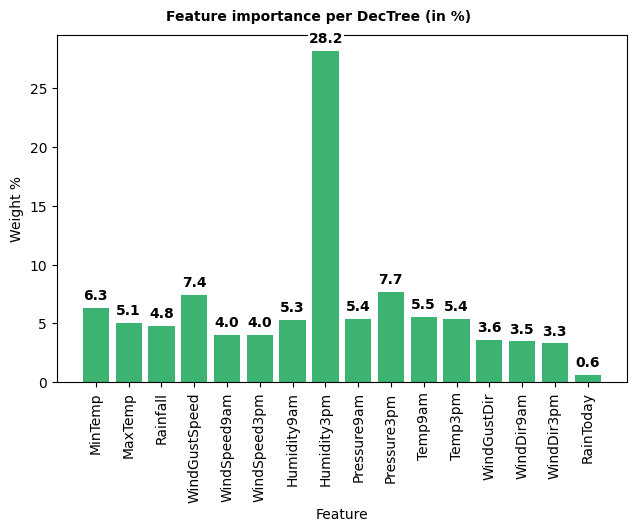

In [ ]:
# Plot:
fig, sub1 = plt.subplots(1, 1, figsize=(600/96, 500/96), constrained_layout=True)
fig.suptitle(f"Feature importance per {MODELNAME} (in %)", fontsize=10, fontweight='bold')

xpos = np.arange(len(f_importance.keys()))
ylist = [v*100 for v in f_importance.values()]
sub1.bar(xpos, ylist, color='mediumseagreen')

for x, y in zip(xpos, ylist):
    lab = f"{y:.1f}"
    xoff = 12 if len(lab) > 3 else 9
    yoff = 4
    plt.annotate(text=f"{y:.1f}",
                xy=(x, y),
                xytext=(-xoff, yoff), #distance from text to points (x,y)
                textcoords="offset points",
                fontweight="bold",
                bbox=dict(boxstyle='round, pad=0', fc='white', ec='1'))

sub1.set_xlabel("Feature")
sub1.set_ylabel("Weight %")
sub1.set_xticks(xpos)
sub1.set_xticklabels(f_importance.keys(), rotation=90)
plt.show()